### **EXPLORATORY DATA ANALISYS**

#### **ALTIERIS M. PEIXOTO**

A partir da definição do tema do trabalho, desenvolva uma análise exploratória inicial sobre os dados.  
As análises podem seguir as estratégias disponibilizadas pelos professores no Moodle, mas precisam apresentar os insights encontrados para os dados do seu problema.

Elabore um documento descrevendo sua análise exploratória usando elementos visuais adequados.  

**O documento deve conter:**

1. Descrição das fontes de dados  
2. Descrição das principais variáveis (features)  
3. Análises inciais de distribuição e/ou correlação com gráficos adequados  
4. Conclusões/ideias/hipóteses iniciais  


#### **1. Descrição das fontes de dados**

No contexto de Cidades Inteligentes, um dos tópicos emergententes é o transporte público e como este influencia diretamente no dia a dia da população.  
Através dos dados disponibilizados pelo site http://dadosabertos.c3sl.ufpr.br/curitibaurbs/ espera-se ter uma melhor idéia da qualidade do transporte público na região de Curitiba.

O presente trabalho tem como proposta realizar uma breve análise exploratória dos dados disponíveis no site, assim como gerar insights para a evolução do trabalho final da displina.

#### **2. Descrição das principais variáveis (features)**

Os dados são disponibilizados diáriamente no portal de dados abertos, entretanto são sempre referentes ao dia anterior e em formato JSON.  

Foi realizada uma coleta dos dados de 01/01/2019 à 31/03/2019 e foi utilizado o [Apache Spark](https://spark.apache.org/) para o processamento das informações.  
O Apache Spark é uma ferramenta da stack de Big Data que possibilita o processamento de grandes conjuntos de dados de forma paralelizada.

#### **INIT SPARK CONTEXT AND SET CONFIGURATIONS**

In [1]:
import findspark
findspark.init()

In [41]:
import pyspark
import random
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SQLContext

conf = SparkConf().setAppName("App")
conf = (conf.setMaster('local[*]')
        .set('spark.executor.memory', '4G')
        .set('spark.driver.memory', '15G')
        .set('spark.driver.maxResultSize', '6G'))

sc = SparkContext.getOrCreate(conf=conf)
sqlContext = SQLContext(sc)

#### **LOAD DATA FILES**

In [42]:
processed_path = '/home/altieris/datascience/data/curitibaurbs/processed/'

In [43]:
linhas = sqlContext.read.json(processed_path+'linhas/')
linhas.registerTempTable("linhas")

In [5]:
pontosLinha = sqlContext.read.json(processed_path+'pontoslinha/')
pontosLinha.registerTempTable("pontos_linha")

In [6]:
tabelaVeiculo = sqlContext.read.json(processed_path+'tabelaveiculo/')
tabelaVeiculo.registerTempTable("tabela_veiculo")

In [7]:
tabelaLinha = sqlContext.read.json(processed_path+'tabelalinha/')
tabelaLinha.registerTempTable("tabela_linha")

In [8]:
trechosItinerarios = sqlContext.read.json(processed_path+'trechositinerarios/')
trechosItinerarios.registerTempTable("trechos_itinerarios")

In [9]:
categoriasOnibus = trechosItinerarios.select('COD_CATEGORIA','NOME_CATEGORIA').distinct()
categoriasOnibus.registerTempTable("categorias_onibus")

In [10]:
tipoItinerarios = trechosItinerarios.select('COD_ITINERARIO','NOME_ITINERARIO').distinct()
tipoItinerarios.registerTempTable("tipos_itinerarios")

In [51]:
empresasOnibus = trechosItinerarios.select("COD_EMPRESA","NOME_EMPRESA").distinct()
empresasOnibus.registerTempTable("empresas_onibus")

In [52]:
position_events = sqlContext.read.json(processed_path+'veiculos/')
position_events.registerTempTable("veiculos")

#### **SHOW DATA**

In [12]:
def executeQuery(table_name):
    query = 'select * from {} limit 10'.format(table_name)
    
    return sqlContext.sql(query)

#### **Linhas de ônibus**

Todas as linhas da Rede Integrada do Transporte Coletivo de Curitiba.

In [44]:
executeQuery('linhas').toPandas().head(10)

,CATEGORIA_SERVICO,COD,NOME,NOME_COR,SOMENTE_CARTAO,SOURCEDATE
0,CONVENCIONAL,464,A. MUNHOZ / J. BOTANICO,AMARELA,S,2019-02-27
1,ALIMENTADOR,226,ABAETE,LARANJA,N,2019-02-27
2,TRONCAL,182,ABRANCHES,AMARELA,N,2019-02-27
3,ALIMENTADOR,332,ACROPOLE,LARANJA,N,2019-02-27
4,ALIMENTADOR,334,AGRICOLA,LARANJA,N,2019-02-27
5,CONVENCIONAL,265,AHU / LOS ANGELES,AMARELA,S,2019-02-27
6,CONVENCIONAL,560,ALFERES POLI,AMARELA,S,2019-02-27
7,ALIMENTADOR,232,ALIANCA,LARANJA,N,2019-02-27
8,ALIMENTADOR,629,ALTO BOQUEIR?O,LARANJA,N,2019-02-27
9,TRONCAL,373,ALTO TARUM?,AMARELA,N,2019-02-27


#### **Pontos de ônibus**

Todos os pontos da linha.

In [46]:
executeQuery('pontos_linha').toPandas().head(10)

,COD,GRUPO,ITINERARY_ID,LAT,LON,NOME,NUM,SENTIDO,SEQ,SOURCEDATE,TIPO
0,010,,481,-25.422482678274,-49.284327553297,"Av. Manoel Ribas, 531 - Merces",110037,Horario,39,2019-03-17,Novo mobiliario
1,010,,481,-25.432681513162,-49.258593202776,"Av. Visc. de Guarapuava, 1692 - Centro",140204,Horario,11,2019-03-17,Novo mobiliario
2,010,,481,-25.432206677422,-49.292185860119,"R. Cap. Souza Franco, 661 - Bigorrilho",180042,Horario,34,2019-03-17,Novo mobiliario
3,011,,482,-25.442672993214,-49.288137735075,"Av. do Batel, 1614 - Batel",180067,Anti-horario,21,2019-03-17,Novo mobiliario
4,011,,482,-25.450261873841,-49.259898163195,"Rua Rockefeller, 1424 - Prado Velho",140265,Anti-horario,31,2019-03-17,Novo mobiliario
5,011,,482,-25.44981,-49.27953,"Rua Alferes Angelo Sampaio, 262 - Agua Verde",150222,Anti-horario,25,2019-03-17,Novo mobiliario
6,011,,482,-25.431270813559,-49.254113440476,"R. Jose de Alencar, 361 - Alto da Rua Quinze",110027,Anti-horario,39,2019-03-17,Novo mobiliario
7,011,,482,-25.42337,-49.25315,"Rua Jose de Alencar, 1391 - Alto da Rua XV",130232,Anti-horario,42,2019-03-17,Novo mobiliario
8,011,,482,-25.416890336817,-49.252919504299,"Rua Augusto Stresser, 908 - Juveve",130234,Anti-horario,44,2019-03-17,Novo mobiliario
9,011,,482,-25.413472422663,-49.281147930059,"R. Dom Alberto Goncalves, 951 - Bom Retiro",120109,Anti-horario,6,2019-03-17,Novo mobiliario


#### **Tabela de horários de cada ônibus**

O número da tabela horária que o veículo executou.

In [47]:
executeQuery('tabela_veiculo').toPandas().head(10)

,COD_LINHA,COD_PONTO,HORARIO,NOME_LINHA,SOURCEDATE,TABELA,VEICULO
0,509,,00:00,MAD. BOQUEIR?O,2019-03-01,1,KB499
1,519,,00:05,MAD. S. FRANCISCO / IGUAPE,2019-03-01,1,EA183
2,509,,00:05,MAD. BOQUEIR?O,2019-03-01,1,KB499
3,608,,00:05,MAD. PINHEIRINHO,2019-03-01,1,HA259
4,209,,00:10,MAD. S. CANDIDA / C. RASO,2019-03-01,1,BC928
5,519,,00:30,MAD. S. FRANCISCO / IGUAPE,2019-03-01,1,EA183
6,209,,00:30,MAD. S. CANDIDA / C. RASO,2019-03-01,1,BC928
7,209,,00:30,MAD. S. CANDIDA / C. RASO,2019-03-01,2,HN606
8,509,,00:30,MAD. BOQUEIR?O,2019-03-01,1,KB499
9,608,,00:35,MAD. PINHEIRINHO,2019-03-01,1,HA259


#### **Tabela horária de cada linha**

Tabela horária de cada linha.

In [16]:
executeQuery('tabela_linha').toPandas().head()

,ADAPT,COD,DIA,HORA,NUM,PONTO,SOURCEDATE,TABELA
0,ELEVADOR,989,1,01:10,,PRACA RUI BARBOSA-CHEGADA MAD.,2019-01-25,1
1,ELEVADOR,989,1,01:20,,PRACA RUI BARBOSA-SAIDA MAD.,2019-01-25,1
2,ELEVADOR,989,1,02:20,,PRACA RUI BARBOSA-CHEGADA MAD.,2019-01-25,1
3,ELEVADOR,989,1,02:30,,PRACA RUI BARBOSA-SAIDA MAD.,2019-01-25,1
4,ELEVADOR,989,1,03:35,,PRACA RUI BARBOSA-CHEGADA MAD.,2019-01-25,1


#### **Tabela de trechos dos itinerários de cada linha**

Trechos dos itinerários das linhas.

In [17]:
executeQuery('trechos_itinerarios').drop('CODIGO_URBS','NOME_EMPRESA','NOME_CATEGORIA','NOME_LINHA','NOME_ITINERARIO','STOP_NAME','TIPO_TRECHO').toPandas().head()

,COD_CATEGORIA,COD_EMPRESA,COD_ITINERARIO,COD_LINHA,COD_PTO_PARADA_TH,COD_PTO_TRECHO_A,COD_PTO_TRECHO_B,EXTENSAO_TRECHO_A_ATE_B,NOME_PTO_ABREVIADO,NOME_PTO_PARADA_TH,PTO_ESPECIAL,SEQ_PONTO_TRECHO_A,SEQ_PONTO_TRECHO_B,SEQ_PTO_ITI_TH,SOURCEDATE,STOP_CODE
0,5,004,909,340,806,806,488,3.148,B.ALTO,TERMINAL BAIRRO ALTO,N,5688,5689,5688,2019-03-15,109120
1,5,004,909,340,908,908,806,3.203,DETRAN/BAI,TUBO DETRAN (SENTIDO BAIRRO),N,5900,5688,5900,2019-03-15,109024
2,5,004,909,340,806,806,908,4.197,B.ALTO,TERMINAL BAIRRO ALTO,N,5688,5900,5688,2019-03-15,109120
3,5,004,909,340,488,488,806,3.162,DETRAN/CEN,TUBO DETRAN (SENTIDO CENTRO),S,5689,5688,5689,2019-03-15,109025
4,1,011,676,616,1192,1192,1193,5.86,PORTAO-FAN,PORTAO-LINHA VERDE(SENT.FANNY),N,5014,5015,5014,2019-03-15,105807


#### **Categorias de ônibus**

In [18]:
executeQuery('categorias_onibus').toPandas().head()

,COD_CATEGORIA,NOME_CATEGORIA
0,27,LIGEIR?O
1,8,CONVENCIONAL
2,6,TRONCAL
3,12,CIRCULAR CENTRO
4,15,MADRUGUEIRO


#### **Empresas de transporte público**

In [55]:
 executeQuery('empresas_onibus').toPandas().head(15)

,COD_EMPRESA,NOME_EMPRESA
0,009,ARAUCARIA/TRANSBUS
1,010,MERCES/PONTUAL
2,011,SORRISO/PIONEIRO
3,003,GLORIA/PONTUAL
4,002,TAMANDARE/PIONEIRO
5,005,CCD/PIONEIRO
6,007,REDENTOR/TRANSBUS
7,008,EXPRESSO AZUL/TRANSBUS
8,004,SANTO ANTONIO/PONTUAL
9,006,S?O JOSE/PIONEIRO


#### **Dados de rastreamento dos ônibus**

In [56]:
executeQuery('veiculos').toPandas().head()

,COD_LINHA,DTHR,LAT,LON,VEIC
0,912,09/01/2019 19:03:29,-25.394321,-49.354671,MN405
1,912,09/01/2019 19:03:28,-25.394348,-49.354696,MN405
2,912,09/01/2019 19:03:26,-25.39441,-49.354755,MN405
3,912,09/01/2019 19:03:09,-25.394508,-49.354866,MN405
4,912,09/01/2019 19:03:05,-25.394536,-49.354948,MN405


#### **3. Análises inciais de distribuição e/ou correlação com gráficos adequados**

In [94]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)

sns.set(rc={'figure.figsize':(25.7,8.27)})


##### **Nº de linhas que cada empresa de ônibus opera**

In [61]:
query = 'select count(distinct ti.cod_linha) as nr_linhas,emp.nome_empresa ' \
        'from trechos_itinerarios ti inner join empresas_onibus emp on (ti.cod_empresa = emp.cod_empresa) ' \
        'where sourcedate =\'2019-03-14\' ' \
        'group by emp.nome_empresa '\
        'order by nr_linhas desc' 
    
linhas_empresa = sqlContext.sql(query).toPandas()

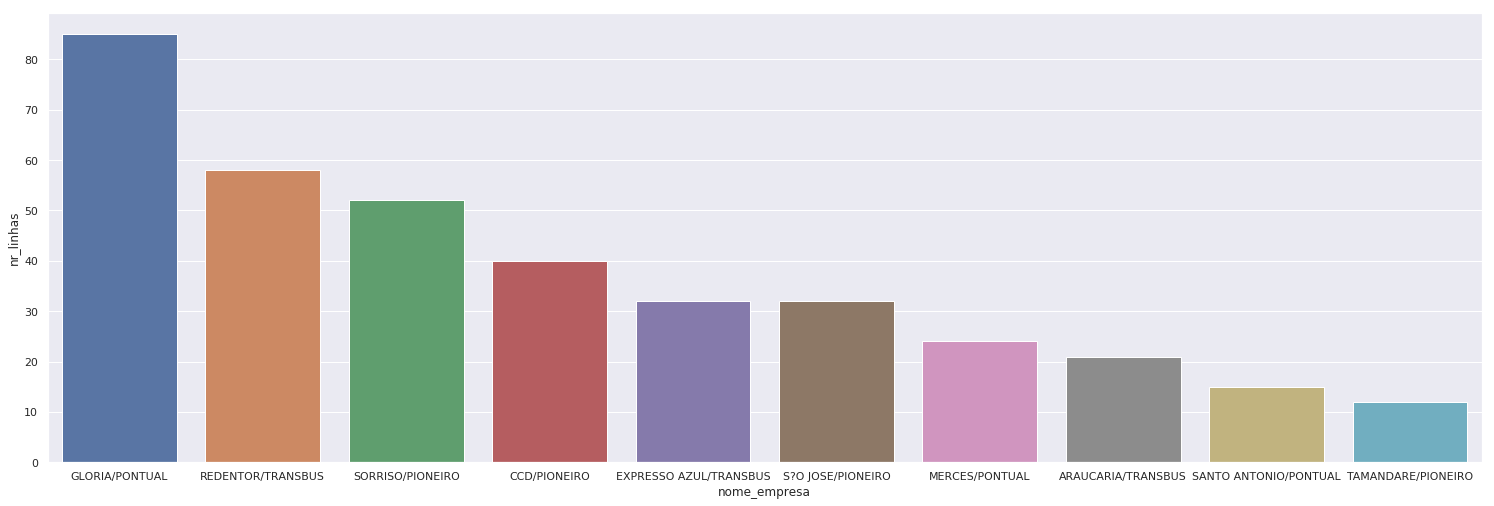

In [62]:
plt.figure(figsize=(25.7,8.27))
sns.barplot(x="nome_empresa", y="nr_linhas", data=linhas_empresa)

In [64]:
query = "select  cat.nome_categoria,emp.nome_empresa,count( distinct li.cod) as qtd_linhas " \
"from trechos_itinerarios ti " \
"inner join categorias_onibus cat on (ti.cod_categoria = cat.cod_categoria) " \
"inner join empresas_onibus emp  on (ti.cod_empresa = emp.cod_empresa) " \
"inner join linhas li on (ti.cod_linha = li.cod and ti.sourcedate = li.sourcedate) " \
"where ti.sourcedate = '2019-03-14' group by cat.nome_categoria,emp.nome_empresa order by qtd_linhas desc"

nr_onibus_categoria_empresa = sqlContext.sql(query).toPandas()

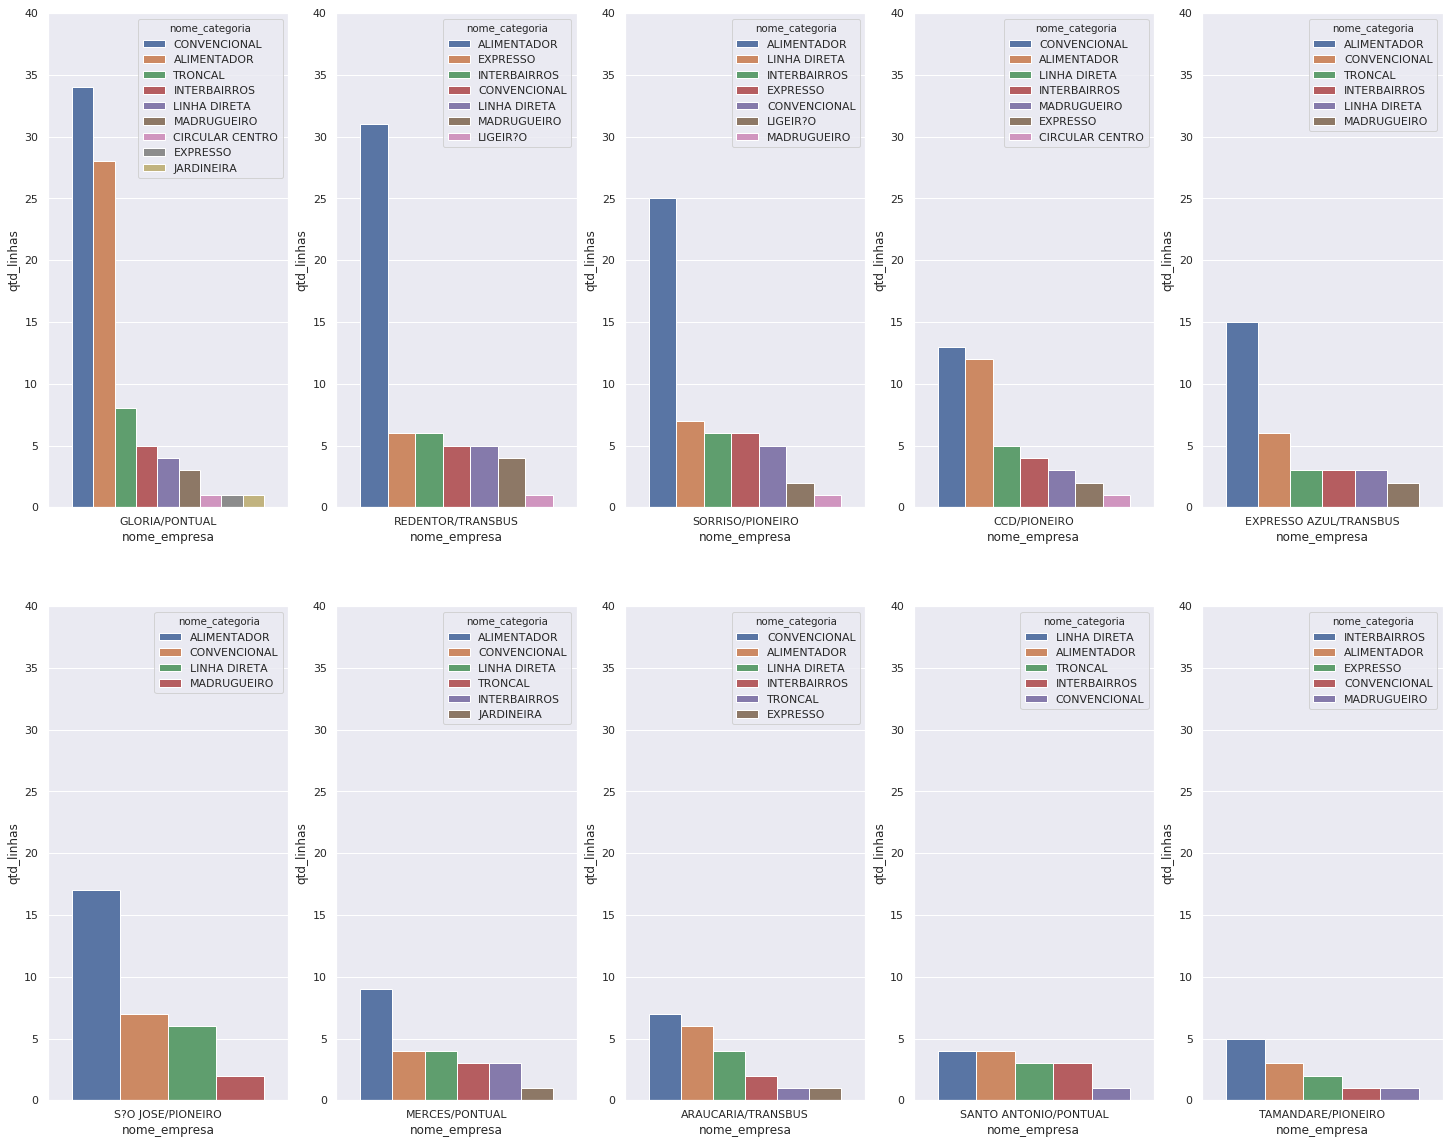

In [148]:
 (fig, ax) = plt.subplots(2,5,figsize=(25,20))

ax[0][0].set(ylim=(0, 40))
ax[0][1].set(ylim=(0, 40))
ax[0][2].set(ylim=(0, 40))
ax[0][3].set(ylim=(0, 40))
ax[0][4].set(ylim=(0, 40))

ax[1][0].set(ylim=(0, 40))
ax[1][1].set(ylim=(0, 40))
ax[1][2].set(ylim=(0, 40))
ax[1][3].set(ylim=(0, 40))
ax[1][4].set(ylim=(0, 40))


sns.barplot(x="nome_empresa", y="qtd_linhas", hue="nome_categoria", data=nr_onibus_categoria_empresa[(nr_onibus_categoria_empresa['nome_empresa']=='GLORIA/PONTUAL')],ax=ax[0][0])
sns.barplot(x="nome_empresa", y="qtd_linhas", hue="nome_categoria", data=nr_onibus_categoria_empresa[(nr_onibus_categoria_empresa['nome_empresa']=='REDENTOR/TRANSBUS')],ax=ax[0][1])
sns.barplot(x="nome_empresa", y="qtd_linhas", hue="nome_categoria", data=nr_onibus_categoria_empresa[(nr_onibus_categoria_empresa['nome_empresa']=='SORRISO/PIONEIRO')],ax=ax[0][2])
sns.barplot(x="nome_empresa", y="qtd_linhas", hue="nome_categoria", data=nr_onibus_categoria_empresa[(nr_onibus_categoria_empresa['nome_empresa']=='CCD/PIONEIRO')],ax=ax[0][3])
sns.barplot(x="nome_empresa", y="qtd_linhas", hue="nome_categoria", data=nr_onibus_categoria_empresa[(nr_onibus_categoria_empresa['nome_empresa']=='EXPRESSO AZUL/TRANSBUS')],ax=ax[0][4])

sns.barplot(x="nome_empresa", y="qtd_linhas", hue="nome_categoria", data=nr_onibus_categoria_empresa[(nr_onibus_categoria_empresa['nome_empresa']=='S?O JOSE/PIONEIRO')],ax=ax[1][0])
sns.barplot(x="nome_empresa", y="qtd_linhas", hue="nome_categoria", data=nr_onibus_categoria_empresa[(nr_onibus_categoria_empresa['nome_empresa']=='MERCES/PONTUAL')],ax=ax[1][1])
sns.barplot(x="nome_empresa", y="qtd_linhas", hue="nome_categoria", data=nr_onibus_categoria_empresa[(nr_onibus_categoria_empresa['nome_empresa']=='ARAUCARIA/TRANSBUS')],ax=ax[1][2])
sns.barplot(x="nome_empresa", y="qtd_linhas", hue="nome_categoria", data=nr_onibus_categoria_empresa[(nr_onibus_categoria_empresa['nome_empresa']=='SANTO ANTONIO/PONTUAL')],ax=ax[1][3])
sns.barplot(x="nome_empresa", y="qtd_linhas", hue="nome_categoria", data=nr_onibus_categoria_empresa[(nr_onibus_categoria_empresa['nome_empresa']=='TAMANDARE/PIONEIRO')],ax=ax[1][4])


##### **Linhas com o maior número de pontos de ônibus**

In [156]:
query = "select  pont.cod,li.nome ,count(distinct pont.num) as qtd_pontos " \
"from pontos_linha pont inner join linhas li on (pont.cod = li.cod) " \
"where li.sourcedate = '2019-03-14' group by pont.cod,li.nome order by qtd_pontos desc"

pontos_linha = sqlContext.sql(query).toPandas()

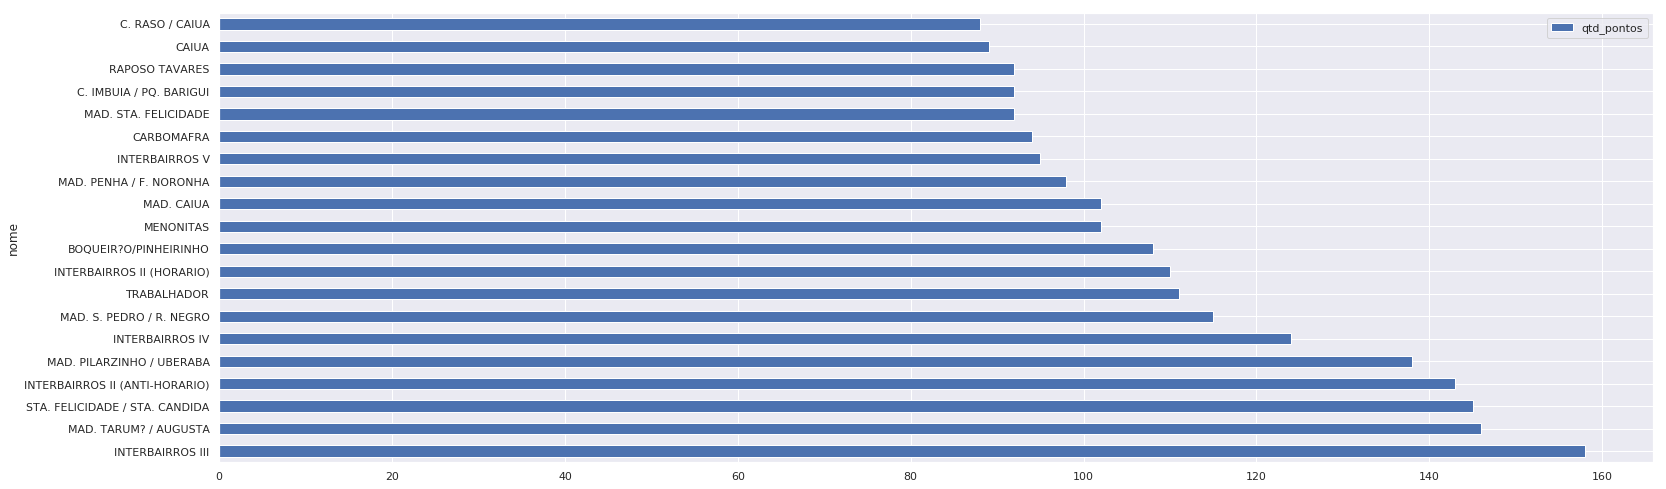

In [177]:
points = pontos_linha.head(20)
points.plot("nome", "qtd_pontos", kind="barh" )

In [224]:
query = "select  veic.cod_linha,li.nome, veic.veic,count(1) as nr_posicoes " \
"from veiculos veic inner join linhas li on (veic.cod_linha = li.cod) " \
"where TO_DATE(CAST(UNIX_TIMESTAMP(veic.dthr, 'dd/MM/yyyy') AS TIMESTAMP)) = '2019-03-14' group by veic.cod_linha,li.nome,veic.veic order by nr_posicoes desc"

#select from_unixtime(unix_timestamp('2016/06/01','yyyy/MM/dd'),'yyyy-MM-dd') from table1; 
pontos_linha = sqlContext.sql(query).toPandas()

In [225]:
pontos_linha.head(10)

,cod_linha,nome,veic,nr_posicoes
0,924,STA. FELICIDADE / STA. CANDIDA,MA013,923074
1,924,STA. FELICIDADE / STA. CANDIDA,MA299,876580
2,913,BUTIATUVINHA,MN401,768586
3,924,STA. FELICIDADE / STA. CANDIDA,MA007,720780
4,823,AUGUSTA,LA011,688882
5,860,V. SANDRA,LC013,673056
6,821,FERN?O DIAS,MA010,665348
7,825,V. MARQUETO,LN006,664692
8,860,V. SANDRA,LC029,634598
9,972,JD. ITALIA,MC307,632466


In [227]:
pontos_linha.sort_values(by=['nr_posicoes'], ascending=True).head(10)

,cod_linha,nome,veic,nr_posicoes
168,809,MAD. CAMPO COMPRIDO,LA851,2050
167,307,B. ALTO / STA. FELICIDADE,ML309,6888
166,828,C. COMPRIDO / C. RASO,LC019,18614
165,814,MOSSUNGUE,LC298,23780
164,024,C. RASO / CAMP. SIQUEIRA,LL306,30176
163,814,MOSSUNGUE,LA002,30832
162,024,C. RASO / CAMP. SIQUEIRA,LL309,32882
161,022,INTER 2 (HORARIO),LR801,42230
160,503,BOQUEIR?O,KE843,42722
159,303,CENTENARIO / C. COMPRIDO,LE849,43296


In [228]:
query = "select  veic.cod_linha,li.nome, veic.veic,count(1) as nr_posicoes " \
"from veiculos veic inner join linhas li on (veic.cod_linha = li.cod) " \
"where TO_DATE(CAST(UNIX_TIMESTAMP(veic.dthr, 'dd/MM/yyyy') AS TIMESTAMP)) = '2019-03-14' and veic.cod_linha ='809' group by veic.cod_linha,li.nome,veic.veic order by nr_posicoes desc"

pontos_linha = sqlContext.sql(query).toPandas()

In [229]:
pontos_linha.head()

,cod_linha,nome,veic,nr_posicoes
0,809,MAD. CAMPO COMPRIDO,LC850,110536
1,809,MAD. CAMPO COMPRIDO,LA851,2050


In [230]:
query = "select  veic.cod_linha,li.nome, veic.veic,veic.dthr " \
"from veiculos veic inner join linhas li on (veic.cod_linha = li.cod) " \
"where TO_DATE(CAST(UNIX_TIMESTAMP(veic.dthr, 'dd/MM/yyyy') AS TIMESTAMP)) = '2019-03-14' and veic.cod_linha ='809' order by veic.veic,veic.dthr "

pontos_linha = sqlContext.sql(query).toPandas()

In [240]:
pontos_linha.groupby(['dthr']).count()

,cod_linha,nome,veic
dthr,,,
14/03/2019 01:10:19,82,82,82
14/03/2019 01:10:42,82,82,82
14/03/2019 01:10:56,82,82,82
14/03/2019 01:11:03,82,82,82
14/03/2019 01:11:08,82,82,82
14/03/2019 01:11:10,82,82,82
14/03/2019 01:11:11,82,82,82
14/03/2019 01:11:14,82,82,82
14/03/2019 01:11:34,82,82,82


#### **4. Conclusões/ideias/hipóteses iniciais**